In [36]:
import os
import pandas as pd
import mne as mne
import numpy as np
import matplotlib.pyplot as plt

In [38]:
!datalad install https://github.com/OpenNeuroDatasets/ds003523.git

In [40]:
!ls /Users/ishabharti/ds003523
dataset_path = '/Users/ishabharti/ds003523'
print(os.listdir(dataset_path))

CHANGES                  sub-026                  sub-059
README                   sub-027                  sub-060
code                     sub-028                  sub-061
dataset_description.json sub-029                  sub-062
ds003523                 sub-030                  sub-063
participants.json        sub-031                  sub-064
participants.tsv         sub-032                  sub-065
stimuli                  sub-033                  sub-066
sub-001                  sub-034                  sub-067
sub-002                  sub-035                  sub-068
sub-003                  sub-036                  sub-069
sub-004                  sub-037                  sub-070
sub-005                  sub-038                  sub-071
sub-006                  sub-039                  sub-072
sub-007                  sub-040                  sub-073
sub-008                  sub-041                  sub-074
sub-009                  sub-042                  sub-075
sub-010       

In [42]:
participants_file = os.path.join(dataset_path, 'participants.tsv')
participants_data = pd.read_csv(participants_file, sep='\t')
print(participants_data.head())

  participant_id  Original_ID       URSI  sex  age  Group
0        sub-001         3044  M87102477    1   23      0
1        sub-002         3009  M87104171    0   30      1
2        sub-003         3042  M87104582    0   19      0
3        sub-004         3074  M87106278    0   19      0
4        sub-005         3076  M87107075    0   22      0


In [2]:
import mne as mne
import numpy as np
import pandas as pd
from scipy.integrate import simpson

# Define the file paths for each subject
subject_files = [
    "/Users/ishabharti/Downloads/sub-001_ses-01_task-VisualWorkingMemory_eeg.set",
    "/Users/ishabharti/Downloads/sub-002_ses-01_task-VisualWorkingMemory_eeg.set",
    "/Users/ishabharti/Downloads/sub-003_ses-01_task-VisualWorkingMemory_eeg.set"
]

# Initialize a list to store wave power results
wave_power_results = []

# Function to calculate wave power for each subject
def calculate_wave_power(file_path):
    # Load the EEG data
    raw_data = mne.io.read_raw_eeglab(file_path, preload=True)

    # Remove or mark bad segments if boundary events exist
    boundary_events = raw_data.annotations[raw_data.annotations.description == 'boundary']
    if len(boundary_events) > 0:
        print(f"Found {len(boundary_events)} boundary events in {file_path}. Removing them.")
        
        # Extract the indices of boundary events and delete them
        boundary_indices = [i for i, ann in enumerate(raw_data.annotations) if ann['description'] == 'boundary']
        raw_data.annotations.delete(boundary_indices)

    # Apply a bandpass filter for alpha waves (8-13 Hz)
    raw_data.filter(8, 13, fir_design='firwin')

    # Extract the power spectral density (PSD) using Welch method
    psd, freqs = mne.time_frequency.psd_welch(raw_data, fmin=0, fmax=50, n_fft=2048)

    # Define the frequency bands for each wave type
    delta_idx = np.logical_and(freqs >= 0.5, freqs < 4)
    theta_idx = np.logical_and(freqs >= 4, freqs < 8)
    alpha_idx = np.logical_and(freqs >= 8, freqs < 13)

    # Calculate power for each frequency band using Simpson's rule
    delta_power = simpson(psd[:, delta_idx], x=freqs[delta_idx])
    theta_power = simpson(psd[:, theta_idx], x=freqs[theta_idx])
    alpha_power = simpson(psd[:, alpha_idx], x=freqs[alpha_idx])
    total_power = simpson(psd, x=freqs)

    # Save the results for the current subject
    return {
        'file': file_path,
        'delta_power': np.sum(delta_power),
        'theta_power': np.sum(theta_power),
        'alpha_power': np.sum(alpha_power),
        'total_power': np.sum(total_power)
    }

# Process each file and store the results
for file in subject_files:
    results = calculate_wave_power(file)
    wave_power_results.append(results)
    print(f"Processed {file} - Results: {results}")

# Convert the results to a DataFrame for better readability
df_results = pd.DataFrame(wave_power_results)

# Save the results to a CSV file
df_results.to_csv('wave_power_results.csv', index=False)

print("Wave power results saved to wave_power_results.csv!")

Reading /Users/ishabharti/Downloads/sub-001_ses-01_task-VisualWorkingMemory_eeg.fdt
Reading 0 ... 697174  =      0.000 ...  1394.348 secs...
Found 1 boundary events in /Users/ishabharti/Downloads/sub-001_ses-01_task-VisualWorkingMemory_eeg.set. Removing them.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 825 samples (1.650 s)



/var/folders/dl/zd_s8q0x20zbxpy0_dzhksbh0000gn/T/ipykernel_20996/2214701420.py:19: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(file_path, preload=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


AttributeError: No mne.time_frequency attribute psd_welch

In [3]:
# Define delta lower and upper limits
low, high = 0.5, 4

# Find intersecting values in frequency vector
idx_delta = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the delta area
plt.figure(figsize=(7, 4))                                                                            
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_delta, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 10])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()

NameError: name 'freqs' is not defined

In [16]:
# Define sampling frequency (example: 1000 Hz)
sf = 1000

from scipy.integrate import simpson

from scipy.signal import welch

subject_files = ["/Users/ishabharti/Downloads/sub-001_ses-01_task-VisualWorkingMemory_eeg.set", "/Users/ishabharti/Downloads/sub-002_ses-01_task-VisualWorkingMemory_eeg.set", "/Users/ishabharti/Downloads/sub-003_ses-01_task-VisualWorkingMemory_eeg.set"]  # Example file paths
data = []
for file in subject_files:
    # Process each file (your existing feature extraction code)
    raw_data = mne.io.read_raw_eeglab(file, preload=True)
    freqs, psd = welch(raw_data.get_data(), sf, nperseg=int(4 * sf))

    # Frequency bands
    delta_idx = (freqs >= 0.5) & (freqs <= 4)
    theta_idx = (freqs >= 4) & (freqs <= 8)
    alpha_idx = (freqs >= 8) & (freqs <= 12)

    # Power calculation
    delta_power = simpson(psd[:, delta_idx], freqs[delta_idx])
    theta_power = simpson(psd[:, theta_idx], freqs[theta_idx])
    alpha_power = simpson(psd[:, alpha_idx], freqs[alpha_idx])

    # Normalize (optional)
    total_power = simpson(psd, freqs)
    delta_norm = delta_power / total_power
    theta_norm = theta_power / total_power
    alpha_norm = alpha_power / total_power

    # Concussion status (replace with actual labels for your data)
    concussion_status = 1 if "concussed" in file else 0

    # Append to data
    data.append({
        "delta_power": delta_norm,
        "theta_power": theta_norm,
        "alpha_power": alpha_norm,
        "concussion_status": concussion_status
    })

# Convert to DataFrame and save
df = pd.DataFrame(data)
df.to_csv("wave_power_results.csv", index=False)
print("Wave power results saved to wave_power_results.csv!")
for file in subject_files:
    # Process each file (your existing feature extraction code)
    raw_data = mne.io.read_raw_eeglab(file, preload=True)
    
    # Assuming 'sf' is the sampling frequency, make sure it's defined before calling welch
    freqs, psd = welch(raw_data.get_data(), sf, nperseg=int(4 * sf))

    # Frequency bands
    delta_idx = (freqs >= 0.5) & (freqs <= 4)
    theta_idx = (freqs >= 4) & (freqs <= 8)
    alpha_idx = (freqs >= 8) & (freqs <= 12)

    # Power calculation
    delta_power = simpson(psd[:, delta_idx], freqs[delta_idx])
    theta_power = simpson(psd[:, theta_idx], freqs[theta_idx])
    alpha_power = simpson(psd[:, alpha_idx], freqs[alpha_idx])

    # Normalize (optional)
    total_power = simpson(psd, freqs)
    delta_norm = delta_power / total_power
    theta_norm = theta_power / total_power
    alpha_norm = alpha_power / total_power

    # Add your concussion status and append to data
    concussion_status = 1 if "concussed" in file else 0
    data.append({
        "delta_power": delta_norm,
        "theta_power": theta_norm,
        "alpha_power": alpha_norm,
        "concussion_status": concussion_status
    })

# Convert to DataFrame and save
df = pd.DataFrame(data)
df.to_csv("wave_power_results.csv", index=False)
print("Wave power results saved to wave_power_results.csv!")

Reading /Users/ishabharti/Downloads/sub-001_ses-01_task-VisualWorkingMemory_eeg.fdt
Reading 0 ... 697174  =      0.000 ...  1394.348 secs...


/var/folders/dl/zd_s8q0x20zbxpy0_dzhksbh0000gn/T/ipykernel_928/3913931019.py:12: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(file, preload=True)


Reading /Users/ishabharti/Downloads/sub-002_ses-01_task-VisualWorkingMemory_eeg.fdt
Reading 0 ... 766849  =      0.000 ...  1533.698 secs...


/var/folders/dl/zd_s8q0x20zbxpy0_dzhksbh0000gn/T/ipykernel_928/3913931019.py:21: DeprecationWarning: You are passing x=[0.5  0.75 1.   1.25 1.5  1.75 2.   2.25 2.5  2.75 3.   3.25 3.5  3.75
 4.  ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  delta_power = simpson(psd[:, delta_idx], freqs[delta_idx])
/var/folders/dl/zd_s8q0x20zbxpy0_dzhksbh0000gn/T/ipykernel_928/3913931019.py:22: DeprecationWarning: You are passing x=[4.   4.25 4.5  4.75 5.   5.25 5.5  5.75 6.   6.25 6.5  6.75 7.   7.25
 7.5  7.75 8.  ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  theta_power = simpson(psd[:, theta_idx], freqs[theta_idx])
/var/folders/dl/zd_s8q0x20zbxpy0_dzhksbh0000gn/T/ipykernel_928/3913931019.py:23: DeprecationWarning: You are passing x=[ 8.    8.25  8.5   8.75  9.   

Reading /Users/ishabharti/Downloads/sub-003_ses-01_task-VisualWorkingMemory_eeg.fdt
Reading 0 ... 856724  =      0.000 ...  1713.448 secs...


/var/folders/dl/zd_s8q0x20zbxpy0_dzhksbh0000gn/T/ipykernel_928/3913931019.py:12: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(file, preload=True)


Wave power results saved to wave_power_results.csv!
Reading /Users/ishabharti/Downloads/sub-001_ses-01_task-VisualWorkingMemory_eeg.fdt
Reading 0 ... 697174  =      0.000 ...  1394.348 secs...


/var/folders/dl/zd_s8q0x20zbxpy0_dzhksbh0000gn/T/ipykernel_928/3913931019.py:48: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(file, preload=True)


Reading /Users/ishabharti/Downloads/sub-002_ses-01_task-VisualWorkingMemory_eeg.fdt
Reading 0 ... 766849  =      0.000 ...  1533.698 secs...


/var/folders/dl/zd_s8q0x20zbxpy0_dzhksbh0000gn/T/ipykernel_928/3913931019.py:59: DeprecationWarning: You are passing x=[0.5  0.75 1.   1.25 1.5  1.75 2.   2.25 2.5  2.75 3.   3.25 3.5  3.75
 4.  ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  delta_power = simpson(psd[:, delta_idx], freqs[delta_idx])
/var/folders/dl/zd_s8q0x20zbxpy0_dzhksbh0000gn/T/ipykernel_928/3913931019.py:60: DeprecationWarning: You are passing x=[4.   4.25 4.5  4.75 5.   5.25 5.5  5.75 6.   6.25 6.5  6.75 7.   7.25
 7.5  7.75 8.  ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  theta_power = simpson(psd[:, theta_idx], freqs[theta_idx])
/var/folders/dl/zd_s8q0x20zbxpy0_dzhksbh0000gn/T/ipykernel_928/3913931019.py:61: DeprecationWarning: You are passing x=[ 8.    8.25  8.5   8.75  9.   

Reading /Users/ishabharti/Downloads/sub-003_ses-01_task-VisualWorkingMemory_eeg.fdt
Reading 0 ... 856724  =      0.000 ...  1713.448 secs...


/var/folders/dl/zd_s8q0x20zbxpy0_dzhksbh0000gn/T/ipykernel_928/3913931019.py:48: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(file, preload=True)


Wave power results saved to wave_power_results.csv!


sub 1 session 1
Reading /Users/ishabharti/Downloads/sub-001_ses-01_task-VisualWorkingMemory_eeg.fdt
Reading 0 ... 697174  =      0.000 ...  1394.348 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 825 samples (1.650 s)



/var/folders/dl/zd_s8q0x20zbxpy0_dzhksbh0000gn/T/ipykernel_1065/1313529377.py:23: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(file_path, preload=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


Using matplotlib as 2D backend.


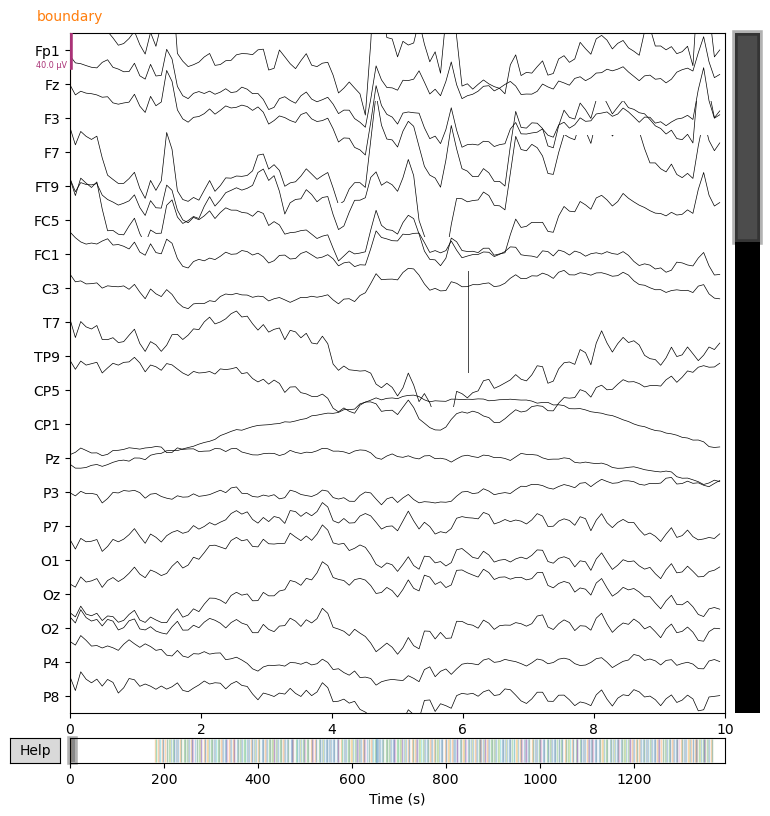

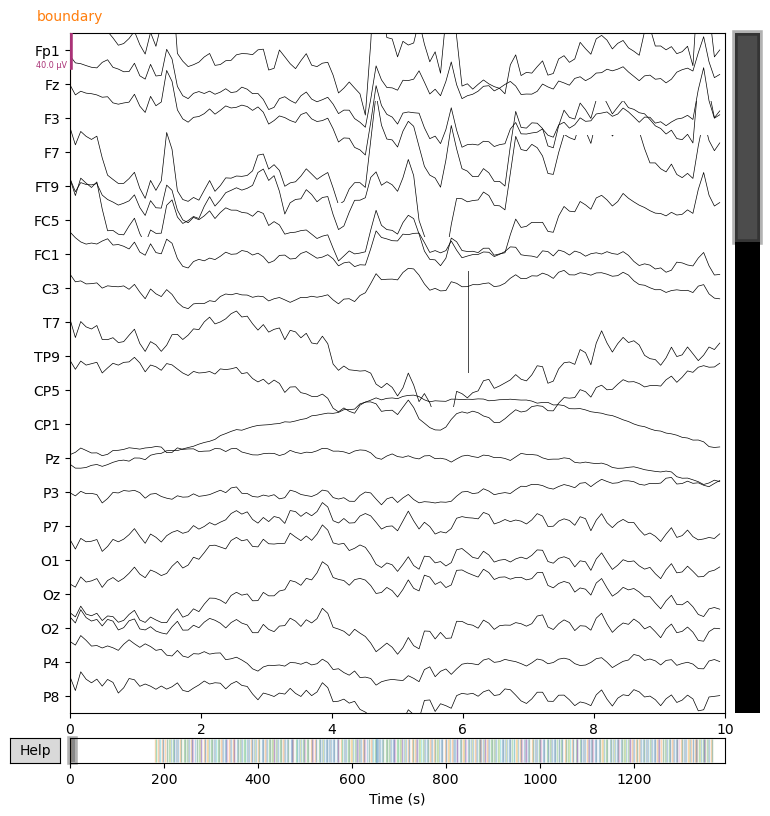

In [19]:
print ('sub 1 session 1')
import mne as mne
import requests

# URL of the EEG data file
url = 'https://s3.amazonaws.com/openneuro.org/ds003523/sub-001/ses-01/eeg/sub-001_ses-01_task-VisualWorkingMemory_eeg.set?versionId=eqK.jPiqsG127Ei_IyM7T2aFXg7_59XP'

# Local path where the file will be saved
local_path = 'sub-001_ses-01_task-VisualWorkingMemory_eeg.set'

# Download the file
#response = requests.get(url)
#with open(local_path, 'wb') as file:
#    file.write(response.content)

#print("File downloaded successfully.")


# Update the file path to where you saved the downloaded .set file
file_path = '/Users/ishabharti/Downloads/sub-001_ses-01_task-VisualWorkingMemory_eeg.set'

# Load the EEG data using MNE's read_raw_eeglab function
raw_data = mne.io.read_raw_eeglab(file_path, preload=True)

# Apply filtering (for example, band-pass filter from 1-50 Hz)
raw_data.filter(l_freq=0, h_freq=4)



# Plot the raw EEG data to visually inspect it
raw_data.plot()




In [18]:
# sepcific delta wave count for subject 001
import mne
import glob
from scipy import signal
from scipy.integrate import simpson
from scipy.integrate import simps

from scipy.signal import find_peaks

# List of all .set files
eeg_files = glob.glob("/Users/ishabharti/Downloads/sub-004_ses-02_task-VisualWorkingMemory_eeg.set")  # Update with correct path

delta_powers = []
delta_wave_counts = []

for file in eeg_files:
    print(f"Processing {file}")
    
    # Load EEG data
    raw_data = mne.io.read_raw_eeglab(file, preload=True)
    
    # Get the sampling frequency from the data
    sf = raw_data.info['sfreq']
    
    # Filter for delta waves (0.5 - 4 Hz)
    delta_data = raw_data.copy().filter(l_freq=0.5, h_freq=4)
    
    # Calculate PSD and delta power
    freqs, psd = signal.welch(raw_data.get_data(), sf, nperseg=int(4 * sf))
    delta_idx = (freqs >= 0.5) & (freqs <= 4)
   # delta_power = simps(psd[:, delta_idx], freqs[delta_idx])
    delta_power = simpson(psd[:, delta_idx], freqs[delta_idx])
    delta_powers.append(delta_power)

    # Count delta waves by detecting peaks and troughs
    eeg_signal = delta_data.get_data()[0]
    peaks, _ = find_peaks(eeg_signal)
    troughs, _ = find_peaks(-eeg_signal)
    delta_wave_count = len(peaks) + len(troughs)
    delta_wave_counts.append(delta_wave_count)
    
    print(f"File: {file}, Delta Power: {delta_power}, Delta Waves: {delta_wave_count}")

Processing /Users/ishabharti/Downloads/sub-004_ses-02_task-VisualWorkingMemory_eeg.set
Reading /Users/ishabharti/Downloads/sub-004_ses-02_task-VisualWorkingMemory_eeg.fdt
Reading 0 ... 524249  =      0.000 ...  1048.498 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 3301 samples (6.602 s)



/var/folders/dl/zd_s8q0x20zbxpy0_dzhksbh0000gn/T/ipykernel_1065/2924604954.py:20: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(file, preload=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


File: /Users/ishabharti/Downloads/sub-004_ses-02_task-VisualWorkingMemory_eeg.set, Delta Power: [1.04968876e-09 4.84042568e-10 5.02347509e-10 5.76216735e-10
 4.32478911e-10 2.54020362e-10 4.75365328e-10 4.62535048e-10
 3.41326079e-10 2.25433503e-10 4.03084160e-10 3.33932994e-10
 3.23346488e-10 2.82079830e-10 2.86331870e-10 3.01551611e-10
 3.07944384e-10 3.36425603e-10 3.69060160e-10 1.48237354e-09
 3.36455295e-10 3.95134708e-10 4.12082964e-10 5.89946637e-10
 3.76078929e-10 2.84121533e-10 4.69732801e-10 5.38681197e-10
 6.41380402e-10 1.14675486e-09 9.64631373e-10 5.92685180e-10
 6.12919829e-10 4.77855686e-10 4.45454722e-10 2.85103068e-10
 4.84506389e-10 4.71843368e-10 4.52688677e-10 7.70578087e-10
 3.21141076e-10 4.26618950e-10 3.23514492e-10 2.92920608e-10
 4.67149399e-10 2.05437391e-10 3.28641261e-10 3.18412735e-10
 2.80826039e-10 3.20372756e-10 3.47546299e-10 3.79817987e-10
 4.10051691e-10 1.93116798e-10 2.23362411e-10 4.68307613e-10
 6.05310585e-10 2.48465782e-10 5.77172450e-10 4.89

/var/folders/dl/zd_s8q0x20zbxpy0_dzhksbh0000gn/T/ipykernel_1065/2924604954.py:32: DeprecationWarning: You are passing x=[0.5  0.75 1.   1.25 1.5  1.75 2.   2.25 2.5  2.75 3.   3.25 3.5  3.75
 4.  ] as a positional argument. Please change your invocation to use keyword arguments. From SciPy 1.14, passing these as positional arguments will result in an error.
  delta_power = simpson(psd[:, delta_idx], freqs[delta_idx])


In [3]:
# theta wave count

import mne
import glob
from scipy import signal
from scipy.integrate import simps
from scipy.signal import find_peaks

# Calculate Power Spectral Density (PSD)
freqs, psd = signal.welch(raw_data.get_data(), sf, nperseg=int(4 * sf))

# Define theta band indices (4–8 Hz)
theta_idx = (freqs >= 4) & (freqs <= 8)

# Calculate theta power using Simpson's rule
theta_power = simps(psd[:, theta_idx], freqs[theta_idx])


# List of all .set files
eeg_files = glob.glob("/Users/ishabharti/Downloads/sub-004_ses-01_task-VisualWorkingMemory_eeg.set")  # Update with correct path

theta_powers = []
theta_wave_counts = []

for file in eeg_files:
    print(f"Processing {file}")
    
    # Load EEG data
    raw_data = mne.io.read_raw_eeglab(file, preload=True)
    
    # Get the sampling frequency from the data
    sf = raw_data.info['sfreq']
    
    # Filter for delta waves (0.5 - 4 Hz)
    theta_data = raw_data.copy().filter(l_freq=4, h_freq=8)
    
    # Calculate PSD and delta power
    freqs, psd = signal.welch(raw_data.get_data(), sf, nperseg=int(4 * sf))
    delta_idx = (freqs >= 4) & (freqs <= 8)
    theta_power = simps(psd[:, theta_idx], freqs[theta_idx])
    theta_powers.append(theta_power)

    # Count delta waves by detecting peaks and troughs
    eeg_signal = theta_data.get_data()[0]
    peaks, _ = find_peaks(eeg_signal)
    troughs, _ = find_peaks(-eeg_signal)
    theta_wave_count = len(peaks) + len(troughs)
    theta_wave_counts.append(theta_wave_count)
    
    print(f"File: {file}, Theta Power: {theta_power}, Theta Waves: {theta_wave_count}")

Processing /Users/ishabharti/Downloads/sub-004_ses-01_task-VisualWorkingMemory_eeg.set
Reading /Users/ishabharti/Downloads/sub-004_ses-01_task-VisualWorkingMemory_eeg.fdt
Reading 0 ... 724399  =      0.000 ...  1448.798 secs...


/var/folders/dl/zd_s8q0x20zbxpy0_dzhksbh0000gn/T/ipykernel_1065/3798411758.py:16: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  theta_power = simps(psd[:, theta_idx], freqs[theta_idx])


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)



/var/folders/dl/zd_s8q0x20zbxpy0_dzhksbh0000gn/T/ipykernel_1065/3798411758.py:29: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(file, preload=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


File: /Users/ishabharti/Downloads/sub-004_ses-01_task-VisualWorkingMemory_eeg.set, Theta Power: [8.87622916e-11 2.42157509e-11 2.75831995e-11 4.77597864e-11
 3.31307287e-11 2.16989471e-11 1.35757111e-11 1.04120256e-11
 2.59564337e-11 4.32266552e-11 1.43691978e-11 1.86321959e-12
 2.34407314e-12 8.36577211e-12 1.97580743e-11 1.72197812e-11
 1.76459500e-11 1.89504047e-11 8.24060239e-12 2.32045048e-11
 3.31296417e-11 1.50748163e-11 2.24071073e-12 3.02186451e-12
 9.73547663e-12 3.16098940e-11 3.17787062e-11 2.03151621e-11
 1.06863022e-11 2.66247957e-11 3.18327679e-11 1.06792614e-10
 5.11569276e-11 4.45151350e-11 4.35671735e-11 2.62357153e-11
 4.76933899e-11 2.67485517e-11 1.65267072e-11 1.41144988e-11
 5.24362166e-12 1.73553796e-11 2.63165577e-11 6.40658917e-12
 3.05325810e-12 8.41645714e-12 1.68669281e-11 8.92454107e-12
 9.12351889e-12 1.07137849e-11 2.24696418e-11 1.35248788e-11
 3.85677363e-12 2.21318203e-10 2.59115961e-11 2.11445918e-11
 4.51315786e-12 1.39106558e-11 2.59321886e-11 2.76

/var/folders/dl/zd_s8q0x20zbxpy0_dzhksbh0000gn/T/ipykernel_1065/3798411758.py:40: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  theta_power = simps(psd[:, theta_idx], freqs[theta_idx])


In [4]:
# alpha wave count for subject 001

import mne
from scipy import signal
import numpy as np
from scipy.signal import find_peaks

# Sampling frequency (adjust according to your dataset)
sf = 1000  # Replace with actual sampling frequency

# File path to EEG data
file_path = '/Users/ishabharti/Downloads/sub-001_ses-01_task-VisualWorkingMemory_eeg.set'

def calculate_alpha_waves(file_path):
    # Load EEG data
    raw_data = mne.io.read_raw_eeglab(file_path, preload=True)

    # Band-pass filter for the alpha frequency range (8–13 Hz)
    alpha_data = raw_data.copy().filter(l_freq=8, h_freq=13)

    # Get EEG data as 2D array (channels x time)
    data = alpha_data.get_data()

    # Welch's method to calculate PSD
    freqs, psd = signal.welch(data, sf, nperseg=4 * sf)

    # Find alpha range (8–13 Hz)
    alpha_idx = (freqs >= 8) & (freqs <= 13)

    # Debug: Inspect PSD and frequency range
    print(f"Alpha PSD (per electrode): {psd[:, alpha_idx]}")

    # Adjust threshold
    threshold = 0.1 * np.max(psd[:, alpha_idx], axis=1, keepdims=True)  # 10% of max PSD

    # Count alpha peaks per electrode
    alpha_peaks = []
    for i in range(psd.shape[0]):
        peaks, _ = find_peaks(psd[i, alpha_idx], height=threshold[i])
        alpha_peaks.append(len(peaks))

    # Print results
    for electrode, count in enumerate(alpha_peaks):
        print(f"Electrode {electrode + 1}: {count} alpha waves")

# Call the function
calculate_alpha_waves(file_path)

Reading /Users/ishabharti/Downloads/sub-001_ses-01_task-VisualWorkingMemory_eeg.fdt
Reading 0 ... 697174  =      0.000 ...  1394.348 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 825 samples (1.650 s)



/var/folders/dl/zd_s8q0x20zbxpy0_dzhksbh0000gn/T/ipykernel_1065/2294166803.py:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(file_path, preload=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Alpha PSD (per electrode): [[4.93182849e-17 5.20651381e-17 4.14413981e-17 ... 2.77651151e-14
  9.79571125e-14 2.56684791e-13]
 [5.60750066e-18 5.88061056e-18 4.77321262e-18 ... 1.07824495e-14
  3.79796816e-14 9.11953678e-14]
 [7.89154075e-18 8.48627904e-18 6.82156070e-18 ... 1.12592285e-14
  3.98242351e-14 9.88385024e-14]
 ...
 [7.15704946e-17 7.55506844e-17 6.16260495e-17 ... 3.98906635e-14
  1.38599152e-13 3.68821189e-13]
 [2.63842028e-12 2.83116886e-12 2.22121226e-12 ... 1.15121973e-09
  3.97750779e-09 9.82263053e-09]
 [9.82182614e-13 8.92687447e-13 5.93838306e-13 ... 1.19523566e-09
  4.15326807e-09 9.44731193e-09]]


ValueError: array size of lower interval border must match x

In [ ]:
# Calculate total power across all frequency bands
total_power = simps(psd, freqs)

# Normalize each band
delta_power_norm = delta_power / total_power
theta_power_norm = theta_power / total_power
alpha_power_norm = alpha_power / total_power

In [ ]:
#generic delta wave count?
# Define delta band (0.5 - 4 Hz)
delta_band = (0.5, 4)

# Filter the EEG data for delta waves
delta_data = raw_data.copy().filter(l_freq=delta_band[0], h_freq=delta_band[1])

# Count zero-crossings for delta waves
from scipy.signal import find_peaks
delta_wave_counts = []
for i, channel in enumerate(delta_data.get_data()):  # Iterate over channels
    zero_crossings = np.where(np.diff(np.sign(channel)))[0]
    delta_wave_counts.append(len(zero_crossings))

# Print the counts for each channel
print("Delta wave counts per channel:", delta_wave_counts)

In [ ]:
raw_data.plot(scalings='auto')


In [ ]:
raw_data.plot()

# sampling frequency
sf = 100

from scipy import signal

# Define window length (4 seconds)
win = 4 * sf
freqs, psd = signal.welch(raw_data, sf, nperseg=win)

# Plot the power spectrum
sns.set(font_scale=1.2, style='white')
plt.figure(figsize=(8, 4))
plt.plot(freqs, psd, color='k', lw=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
plt.xlim([0, freqs.max()])
sns.despine()

In [ ]:
print ('sub 2 session 1')
import mne as mne
import requests

# URL of the EEG data file
url = 'https://s3.amazonaws.com/openneuro.org/ds003523/sub-002/ses-01/eeg/sub-002_ses-01_task-VisualWorkingMemory_eeg.fdt?versionId=YnBO3PjrDO5N52Fm_bW2Ybeuk2WfdxAh'

# Local path where the file will be saved
local_path = 'sub-002_ses-01_task-VisualWorkingMemory_eeg.set'

# Download the file
response = requests.get(url)
with open(local_path, 'wb') as file:
    file.write(response.content)

#print("File downloaded successfully.")


# Update the file path to where you saved the downloaded .set file
file_path = '/Users/ishabharti/Downloads/sub-002_ses-01_task-VisualWorkingMemory_eeg.set'

# Load the EEG data using MNE's read_raw_eeglab function
raw_data = mne.io.read_raw_eeglab(file_path, preload=True)

# Apply filtering (for example, band-pass filter from 1-50 Hz)
raw_data.filter(l_freq=0, h_freq=4)



# Plot the raw EEG data to visually inspect it
raw_data.plot()







In [ ]:
# sepcific delta wave count for subject 002
import mne
import glob
from scipy import signal
from scipy.integrate import simps
from scipy.signal import find_peaks

# List of all .set files
eeg_files = glob.glob("/Users/ishabharti/Downloads/sub-002_ses-01_task-VisualWorkingMemory_eeg.set")  # Update with correct path

delta_powers = []
delta_wave_counts = []

for file in eeg_files:
    print(f"Processing {file}")
    
    # Load EEG data
    raw_data = mne.io.read_raw_eeglab(file, preload=True)
    
    # Get the sampling frequency from the data
    sf = raw_data.info['sfreq']
    
    # Filter for delta waves (0.5 - 4 Hz)
    delta_data = raw_data.copy().filter(l_freq=0.5, h_freq=4)
    
    # Calculate PSD and delta power
    freqs, psd = signal.welch(raw_data.get_data(), sf, nperseg=int(4 * sf))
    delta_idx = (freqs >= 0.5) & (freqs <= 4)
    delta_power = simps(psd[:, delta_idx], freqs[delta_idx])
    delta_powers.append(delta_power)

    # Count delta waves by detecting peaks and troughs
    eeg_signal = delta_data.get_data()[0]
    peaks, _ = find_peaks(eeg_signal)
    troughs, _ = find_peaks(-eeg_signal)
    delta_wave_count = len(peaks) + len(troughs)
    delta_wave_counts.append(delta_wave_count)
    
    print(f"File: {file}, Delta Power: {delta_power}, Delta Waves: {delta_wave_count}")


In [5]:
# alpha wave count for subject 002


import mne
from scipy import signal
import numpy as np

# Sampling frequency (adjust this according to your dataset)
sf = 1000  # Update based on your dataset's actual sampling frequency

# Specify the file path to your EEG data
file_path = '/Users/ishabharti/Downloads/sub-002_ses-01_task-VisualWorkingMemory_eeg.set'  # Replace with actual path

# Function to calculate alpha waves (8-13 Hz) for a single file
def calculate_alpha_waves(file_path):
    # Load the EEG data
    raw_data = mne.io.read_raw_eeglab(file_path, preload=True)

    # Band-pass filter for the alpha frequency range (8–13 Hz)
    alpha_data = raw_data.copy().filter(l_freq=8, h_freq=13)

    # Get the EEG data (channels x timepoints)
    data = alpha_data.get_data()

    # Initialize a counter for alpha waves
    total_alpha_waves = 0

    # Process each channel individually
    for channel_data in data:
        # Use Welch's method to compute the Power Spectral Density (PSD)
        freqs, psd = signal.welch(channel_data, sf, nperseg=4 * sf)

        # Find the alpha frequency range (8-13 Hz)
        alpha_idx = (freqs >= 8) & (freqs <= 13)

        # Count peaks in the alpha range of the PSD
        alpha_psd = psd[alpha_idx]
        alpha_wave_count = np.sum(alpha_psd > np.mean(alpha_psd))

        # Add to the total alpha wave count
        total_alpha_waves += alpha_wave_count

    # Print the results for this file
    print(f"File: {file_path}, Total Alpha Waves: {total_alpha_waves}")

# Call the function to calculate alpha waves for the selected file
calculate_alpha_waves(file_path)
    

Reading /Users/ishabharti/Downloads/sub-002_ses-01_task-VisualWorkingMemory_eeg.fdt
Reading 0 ... 766849  =      0.000 ...  1533.698 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 825 samples (1.650 s)



/var/folders/dl/zd_s8q0x20zbxpy0_dzhksbh0000gn/T/ipykernel_1065/3078952483.py:17: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(file_path, preload=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


File: /Users/ishabharti/Downloads/sub-002_ses-01_task-VisualWorkingMemory_eeg.set, Total Alpha Waves: 195


In [ ]:
print ('sub 3 session 1')

import mne as mne
import requests

# URL of the EEG data file
url = 'https://s3.amazonaws.com/openneuro.org/ds003523/sub-003/ses-01/eeg/sub-003_ses-01_task-VisualWorkingMemory_eeg.fdt?versionId=0NXQ7G6bKfCITwuE6LMiprPrY5nx8eYV'

# Local path where the file will be saved
local_path = 'sub-003_ses-01_task-VisualWorkingMemory_eeg.set'

# Download the file
#response = requests.get(url)
#with open(local_path, 'wb') as file:
#    file.write(response.content)

#print("File downloaded successfully.")


# Update the file path to where you saved the downloaded .set file
file_path = '/Users/ishabharti/Downloads/sub-003_ses-01_task-VisualWorkingMemory_eeg.set'

# Load the EEG data using MNE's read_raw_eeglab function
raw_data = mne.io.read_raw_eeglab(file_path, preload=True)

# Apply filtering (for example, band-pass filter from 1-50 Hz)
raw_data.filter(l_freq=0, h_freq=4)



# Plot the raw EEG data to visually inspect it
raw_data.plot()


In [ ]:
# sepcific delta wave count for subject 003
import mne
import glob
from scipy import signal
from scipy.integrate import simps
from scipy.signal import find_peaks

# List of all .set files
eeg_files = glob.glob("/Users/ishabharti/Downloads/sub-003_ses-01_task-VisualWorkingMemory_eeg.set")  # Update with correct path

delta_powers = []
delta_wave_counts = []

for file in eeg_files:
    print(f"Processing {file}")
    
    # Load EEG data
    raw_data = mne.io.read_raw_eeglab(file, preload=True)
    
    # Get the sampling frequency from the data
    sf = raw_data.info['sfreq']
    
    # Filter for delta waves (0.5 - 4 Hz)
    delta_data = raw_data.copy().filter(l_freq=0.5, h_freq=4)
    
    # Calculate PSD and delta power
    freqs, psd = signal.welch(raw_data.get_data(), sf, nperseg=int(4 * sf))
    delta_idx = (freqs >= 0.5) & (freqs <= 4)
    delta_power = simps(psd[:, delta_idx], freqs[delta_idx])
    delta_powers.append(delta_power)

    # Count delta waves by detecting peaks and troughs
    eeg_signal = delta_data.get_data()[0]
    peaks, _ = find_peaks(eeg_signal)
    troughs, _ = find_peaks(-eeg_signal)
    delta_wave_count = len(peaks) + len(troughs)
    delta_wave_counts.append(delta_wave_count)
    
    print(f"File: {file}, Delta Power: {delta_power}, Delta Waves: {delta_wave_count}")


In [10]:
##alpha wave count for subject 3

import mne
from scipy import signal
import numpy as np

# Sampling frequency (adjust this according to your dataset)
sf = 1000  # Update based on your dataset's sampling frequency

# Specify the file path to your EEG data (update this with the correct path)
file_path = '/Users/ishabharti/Downloads/sub-004_ses-02_task-VisualWorkingMemory_eeg.set'  # Replace with actual path

# Function to calculate alpha waves (8-13 Hz) for a single file
def calculate_alpha_waves(file_path):
    # Load the EEG data
    raw_data = mne.io.read_raw_eeglab(file_path, preload=True)

    # Band-pass filter for the alpha frequency range (8–13 Hz)
    alpha_data = raw_data.copy().filter(l_freq=8, h_freq=13)

    # Get the EEG data and the corresponding frequency values using Welch's method
    # Flatten the data to 1D for the analysis
    freqs, psd = signal.welch(alpha_data.get_data().flatten(), sf, nperseg=4 * sf)

    # Find the alpha frequency range (8 - 13 Hz)
    alpha_idx = (freqs >= 8) & (freqs <= 13)

    # Count the number of alpha waves by detecting peaks (as an example)
    alpha_peaks = np.sum(psd[alpha_idx] > np.mean(psd[alpha_idx]))

    # Print the results for this file
    ##print(f"File: {file_path}, Alpha Waves: {alpha_peaks}")
    print(f"File: {file}, Alpha Power: {alpha_power}, Alpha Waves: {alpha_wave_count}")
# Call the function to calculate alpha waves for the selected file
calculate_alpha_waves(file_path)

Reading /Users/ishabharti/Downloads/sub-004_ses-02_task-VisualWorkingMemory_eeg.fdt
Reading 0 ... 524249  =      0.000 ...  1048.498 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 13 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 13.00 Hz
- Upper transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 14.62 Hz)
- Filter length: 825 samples (1.650 s)



/var/folders/dl/zd_s8q0x20zbxpy0_dzhksbh0000gn/T/ipykernel_1065/3169996371.py:16: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(file_path, preload=True)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


NameError: name 'alpha_power' is not defined

In [ ]:
# sepcific delta wave count for subject 004
import mne
import glob
from scipy import signal
from scipy.integrate import simps
from scipy.signal import find_peaks



# List of all .set files
eeg_files = glob.glob("/Users/ishabharti/Downloads/sub-004_ses-01_task-VisualWorkingMemory_eeg.set")  # Update with correct path

delta_powers = []
delta_wave_counts = []

for file in eeg_files:
    print(f"Processing {file}")
    
    # Load EEG data
    raw_data = mne.io.read_raw_eeglab(file, preload=True)
    
    # Get the sampling frequency from the data
    sf = raw_data.info['sfreq']
    
    # Filter for delta waves (0.5 - 4 Hz)
    delta_data = raw_data.copy().filter(l_freq=0.5, h_freq=4)
    
    # Calculate PSD and delta power
    freqs, psd = signal.welch(raw_data.get_data(), sf, nperseg=int(4 * sf))
    delta_idx = (freqs >= 0.5) & (freqs <= 4)
    delta_power = simps(psd[:, delta_idx], freqs[delta_idx])
    delta_powers.append(delta_power)

    # Count delta waves by detecting peaks and troughs
    eeg_signal = delta_data.get_data()[0]
    peaks, _ = find_peaks(eeg_signal)
    troughs, _ = find_peaks(-eeg_signal)
    delta_wave_count = len(peaks) + len(troughs)
    delta_wave_counts.append(delta_wave_count)
    
    print(f"File: {file}, Delta Power: {delta_power}, Delta Waves: {delta_wave_count}")


In [ ]:
import mne
from scipy import signal
import numpy as np

# Sampling frequency (adjust this according to your dataset)
sf = 1000  # Update based on your dataset's sampling frequency

# Specify the file path to your EEG data (update this with the correct path)
file_path = '/Users/ishabharti/Downloads/sub-004_ses-01_task-VisualWorkingMemory_eeg.set'  # Replace with actual path

# Function to calculate alpha waves (8-13 Hz) for a single file
def calculate_alpha_waves(file_path):
    # Load the EEG data
    raw_data = mne.io.read_raw_eeglab(file_path, preload=True)

    # Band-pass filter for the alpha frequency range (8–13 Hz)
    alpha_data = raw_data.copy().filter(l_freq=8, h_freq=13)

    # Get the EEG data and the corresponding frequency values using Welch's method
    # Flatten the data to 1D for the analysis
    freqs, psd = signal.welch(alpha_data.get_data().flatten(), sf, nperseg=4 * sf)

    # Find the alpha frequency range (8 - 13 Hz)
    alpha_idx = (freqs >= 8) & (freqs <= 13)

    # Count the number of alpha waves by detecting peaks (as an example)
    alpha_peaks = np.sum(psd[alpha_idx] > np.mean(psd[alpha_idx]))

    # Print the results for this file
    print(f"File: {file_path}, Alpha Waves: {alpha_peaks}")

# Call the function to calculate alpha waves for the selected file
calculate_alpha_waves(file_path)

In [ ]:
mne.Evoked.filter

In [ ]:
evk = raw_data.compute_psd()
evk.plot(picks="data", exclude="bads", amplitude=False)



In [ ]:
print(raw_data)

In [ ]:
raw_data

In [ ]:
import mne
from scipy import signal
import numpy as np

# Sampling frequency (adjust this according to your dataset)
sf = 1000  # Update based on your dataset's sampling frequency

# Specify the file path to your EEG data (update this with the correct path)
file_path = '/Users/ishabharti/Downloads/sub-001_ses-01_task-VisualWorkingMemory_eeg.set'  # Replace with actual path

# Function to calculate alpha waves (8-13 Hz) for a single file
def calculate_alpha_waves(file_path):
    # Load the EEG data
    raw_data = mne.io.read_raw_eeglab(file_path, preload=True)

    # Band-pass filter for the alpha frequency range (8–13 Hz)
    alpha_data = raw_data.copy().filter(l_freq=8, h_freq=13)

    # Get the EEG data and the corresponding frequency values using Welch's method
    # Flatten the data to 1D for the analysis
    freqs, psd = signal.welch(alpha_data.get_data().flatten(), sf, nperseg=4 * sf)

    # Find the alpha frequency range (8 - 13 Hz)
    alpha_idx = (freqs >= 8) & (freqs <= 13)

    # Count the number of alpha waves by detecting peaks (as an example)
    alpha_peaks = np.sum(psd[alpha_idx] > np.mean(psd[alpha_idx]))

    # Print the results for this file
    print(f"File: {file_path}, Alpha Waves: {alpha_peaks}")

# Call the function to calculate alpha waves for the selected file
calculate_alpha_waves(file_path)

Reading /Users/ishabharti/Downloads/sub-001_ses-01_task-VisualWorkingMemory_eeg.fdt
Reading 0 ... 697174  =      0.000 ...  1394.348 secs...


/var/folders/dl/zd_s8q0x20zbxpy0_dzhksbh0000gn/T/ipykernel_35762/3175596041.py:135: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(file, preload=True)


Found  1  boundary events. Removing them.
['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2', 'AF7', 'AF3', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'FCz', 'C1', 'C5', 'TP7', 'CP3', 'P1', 'P5', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'P2', 'CP4', 'TP8', 'C6', 'C2', 'FC4', 'FT8', 'F6', 'F2', 'AF4', 'AF8', 'VEOG', 'EKG']
CHANNNEL: Fp1
Results: 1.4165508905793925e-09
delta: 0.6415782243243575
theta: 0.08821642421662385
alpha: 0.017342185660519562
beta: 0.012291451179774262
gamma: 0.020482959979417494
low: 0.216067931927932
high: 0.004020822711375284
CHANNNEL: Fz
Results: 1.6856282919199134e-10
delta: 0.4735112287653827
theta: 0.1478472744213215
alpha: 0.05963593294018826
beta: 0.038611751535935435
gamma: 0.02031958677195781
low: 0.25518255330637807
high: 0.004891672258836378
CHANNNEL: F3
Results: 2.457690009566957e-10
delta: 0.54254212248685

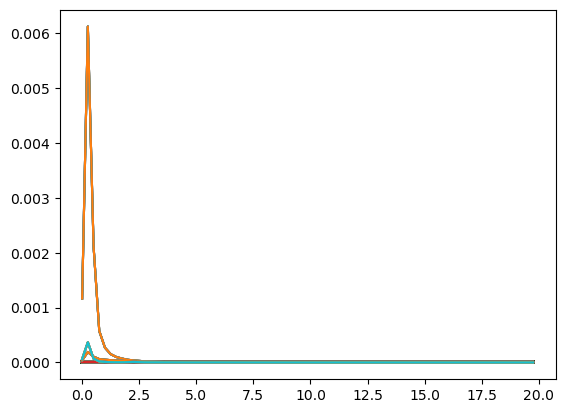

In [2]:
import os
import pandas as pd
import mne as mne
import numpy as np
import matplotlib.pyplot as plt

# !ls /Users/pbharti/ds003523
# dataset_path = '/Users/ishabharti/ds003523'
# print(os.listdir(dataset_path))

# participants_file = os.path.join(dataset_path, 'participants.tsv')
# participants_data = pd.read_csv(participants_file, sep='\t')
# print(participants_data.head())

import mne as mne
import numpy as np
import pandas as pd
from scipy.integrate import simpson

# Define the file paths for each subject
subject_files = [
    "/Users/ishabharti/Downloads/sub-001_ses-01_task-VisualWorkingMemory_eeg.set"
]

# Initialize a list to store wave power results
wave_power_results = []

# Function to calculate wave power for each subject


def bandpower(data, sf, band, window_sec=None, relative=False):
    """Compute the average power of the signal x in a specific frequency band.

    Parameters
    ----------
    data : 1d-array
        Input signal in the time-domain.
    sf : float
        Sampling frequency of the data.
    band : list
        Lower and upper frequencies of the band of interest.
    window_sec : float
        Length of each window in seconds.
        If None, window_sec = (1 / min(band)) * 2
    relative : boolean
        If True, return the relative power (= divided by the total power of the signal).
        If False (default), return the absolute power.

    Return
    ------
    bp : float
        Absolute or relative band power.
    """
    from scipy.signal import welch
    from scipy.integrate import simpson
    band = np.asarray(band)
    low, high = band

    # Define window length
    if window_sec is not None:
        nperseg = window_sec * sf
    else:
        nperseg = (2 / low) * sf

#    print("Shape",data.shape)

    # Compute the modified periodogram (Welch)
    freqs, psd = welch(data, sf, nperseg=nperseg)
    plt.plot(freqs[0:80], psd[0:80])

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find closest indices of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using Simpson's rule.
  #  print(freq_res)
  #  print(idx_band)
  #  print(type(idx_band))
  #  print(type(psd))
  #  j = psd[idx_band]
    bp = simpson(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simpson(psd, dx=freq_res)
    return bp


def calculate_wave_power(file_path):
    # Load the EEG data
    import mne as mne
    raw_data = mne.io.read_raw_eeglab(file_path, preload=True)

    # Remove or mark bad segments if boundary events exist
    boundary_events = raw_data.annotations[raw_data.annotations.description == 'boundary']
    if len(boundary_events) > 0:
        print("Found {len(boundary_events)} boundary events. Removing them.")
        
        # Extract the indices of boundary events and delete them
        boundary_indices = [i for i, ann in enumerate(raw_data.annotations) if ann['description'] == 'boundary']
        raw_data.annotations.delete(boundary_indices)

    # Apply a bandpass filter for alpha waves (8-13 Hz)
    raw_data.filter(8, 13, fir_design='firwin')

    # Extract the power spectral density (PSD) using Welch method
    psd, freqs = mne.time_frequency.psd_welch(raw_data, fmin=0, fmax=50, n_fft=2048)

    # Define the frequency bands for each wave type
    delta_idx = np.logical_and(freqs >= 0.5, freqs < 4)
    theta_idx = np.logical_and(freqs >= 4, freqs < 8)
    alpha_idx = np.logical_and(freqs >= 8, freqs < 13)

    # Calculate power for each frequency band using Simpson's rule
    delta_power = simpson(psd[:, delta_idx], x=freqs[delta_idx])
    theta_power = simpson(psd[:, theta_idx], x=freqs[theta_idx])
    alpha_power = simpson(psd[:, alpha_idx], x=freqs[alpha_idx])
    total_power = simpson(psd, x=freqs)

    # Save the results for the current subject
    return {
        'file': file_path,
        'delta_power': np.sum(delta_power),
        'theta_power': np.sum(theta_power),
        'alpha_power': np.sum(alpha_power),
        'total_power': np.sum(total_power)
    }

# Process each file and store the results
for file in subject_files:
#    results = calculate_wave_power(file)
    sf = 500
    win_sec = 4
    raw_data = mne.io.read_raw_eeglab(file, preload=True)
        # Remove or mark bad segments if boundary events exist
    boundary_events = raw_data.annotations[raw_data.annotations.description == 'boundary']
    if len(boundary_events) > 0:
        print("Found ",len(boundary_events)," boundary events. Removing them.")
        
        # Extract the indices of boundary events and delete them
        boundary_indices = [i for i, ann in enumerate(raw_data.annotations) if ann['description'] == 'boundary']
        raw_data.annotations.delete(boundary_indices)
    
    print(raw_data.ch_names)

    for chann in raw_data.ch_names:
        
#   raw_data.filter(.5, 100, fir_design='firwin')
        print("CHANNNEL:",chann)
        eeg_data = raw_data.get_data(picks=chann) 
#    x = eeg_data.mean()
#    print("x:",x)
#    print("EEG:",eeg_data)
        eeg_data = eeg_data - eeg_data.mean()
#    print("EEG:",eeg_data)
#    print(type(eeg_data))
#    print("Number of channels: ", str(len(eeg_data)))
#        results = bandpower(eeg_data[0], sf, [0.5, 4], win_sec)
#        print("Results:",results)
        results_delta = bandpower(eeg_data[0], sf, [0.5, 4], win_sec,True)
        print("delta:",results_delta)
        results_theta = bandpower(eeg_data[0], sf, [4, 8], win_sec,True)
        print("theta:",results_theta)
        results_alpha = bandpower(eeg_data[0], sf, [8, 13], win_sec,True)
        print("alpha:",results_alpha)
        results_beta = bandpower(eeg_data[0], sf, [13, 30], win_sec,True)
        print("beta:",results_beta)
        results_gamma = bandpower(eeg_data[0], sf, [30, 100], win_sec,True)
        print("gamma:",results_gamma)
        results_low = bandpower(eeg_data[0], sf, [0, 0.5], win_sec,True)
        print("low:",results_low)
        results_high = bandpower(eeg_data[0], sf, [100,100000000], win_sec,True)
        print("high:",results_high)
    
        #wave_power_results.append(results)
        #print(f"Processed {file} - Results: {results}")

# Convert the results to a DataFrame for better readability
df_results = pd.DataFrame(wave_power_results)

# Save the results to a CSV file
df_results.to_csv('wave_power_results.csv', index=False)

print("Wave power results saved to wave_power_results.csv!")